**The competition dataset is based on the 2016 NYC Yellow Cab trip record data made available in Big Query on Google Cloud Platform. The data was originally published by the NYC Taxi and Limousine Commission (TLC). The data was sampled and cleaned for the purposes of this playground competition. Based on individual trip attributes, participants should predict the duration of each trip in the test set.**

The training set (contains 1458644 trip records)
https://www.kaggle.com/c/nyc-taxi-trip-duration/data

# Data fields
- **id** - a unique identifier for each trip
- **vendor_id** - a code indicating the provider associated with the trip record
- **pickup_datetime** - date and time when the meter was engaged
- **dropoff_datetime** - date and time when the meter was disengaged
- **passenger_count** - the number of passengers in the vehicle (driver entered value)
- **pickup_longitude** - the longitude where the meter was engaged
- **pickup_latitude** - the latitude where the meter was engaged
- **dropoff_longitude** - the longitude where the meter was disengaged
- **dropoff_latitude** - the latitude where the meter was disengaged
- **store_and_fwd_flag** - This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server - Y=store and forward; N=not a store and forward trip
- **trip_duration** - duration of the trip in seconds

## The challenge is to predict journey time of taxi trips in New York city

#### install Libraries.

Open console and write each of the following one at a time:
   - conda install -c anaconda basemap
   - conda install -c conda-forge haversine
   - conda install -c conda-forge geopy
   - conda install -c conda-forge folium

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

from mpl_toolkits.basemap import Basemap
from matplotlib import cm

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="white", palette="muted", color_codes=True)
import pandas as pd
pd.options.mode.chained_assignment = None 
import numpy as np

from haversine import haversine
from scipy.spatial.distance import euclidean , cityblock
from geopy.distance import great_circle
from math import *

from bokeh.io import output_notebook,show
from bokeh.models import HoverTool
from bokeh.plotting import figure
from bokeh.palettes import Spectral4

import folium 
from folium import plugins
from folium.plugins import HeatMap

In [11]:
data = pd.read_csv('Dataset/train.csv', nrows = 50000)
#data.to_csv('NYC sub.csv')
data.head()

id  vendor_id      pickup_datetime     dropoff_datetime  \
0  id2875421          2  2016-03-14 17:24:55  2016-03-14 17:32:30   
1  id2377394          1  2016-06-12 00:43:35  2016-06-12 00:54:38   
2  id3858529          2  2016-01-19 11:35:24  2016-01-19 12:10:48   
3  id3504673          2  2016-04-06 19:32:31  2016-04-06 19:39:40   
4  id2181028          2  2016-03-26 13:30:55  2016-03-26 13:38:10   

   passenger_count  pickup_longitude  pickup_latitude  dropoff_longitude  \
0                1        -73.982155        40.767937         -73.964630   
1                1        -73.980415        40.738564         -73.999481   
2                1        -73.979027        40.763939         -74.005333   
3                1        -74.010040        40.719971         -74.012268   
4                1        -73.973053        40.793209         -73.972923   

   dropoff_latitude store_and_fwd_flag  trip_duration  
0         40.765602                  N            455  
1         40.731152                  N            663  
2         40.710087                  N           2124  
3         40.706718                  N            429  
4         40.782520                  N            435

## Plan and workflow:

- First we will perform general EDA (Eexploratory Data Analysis.
- Visualize features and explore data types and correlations.
- Then we proceed with preprocessing:
    - Missing values.
    - Check outliers.
- Then we conclude our Analysis.
-

This is just a cool action to show you a visualized map of the dropoff points between January to June. If you want to understand the code by all means go ahead and check the source from here: https://www.kaggle.com/poonaml/last-cab-to-new-york-animated-heatmap-trips-folium

In [12]:
west, south, east, north = -74.03, 40.63, -73.77, 40.85
train = data
train = train[(train.pickup_latitude> south) & (train.pickup_latitude < north)]
train = train[(train.dropoff_latitude> south) & (train.dropoff_latitude < north)]
train = train[(train.pickup_longitude> west) & (train.pickup_longitude < east)]
train = train[(train.dropoff_longitude> west) & (train.dropoff_longitude < east)]

In [13]:
#Extract the month column from pickup datetime variable and take subset of data
train['dropoff_datetime'] = pd.to_datetime(train.dropoff_datetime)
train['dropoff_month'] = train['dropoff_datetime'].dt.month

heat_df =train.sample(n=2500)

#Extract required columns
heat_df = heat_df[['dropoff_latitude', 'dropoff_longitude','dropoff_month']]


# Ensure you're handing it floats
heat_df['dropoff_latitude'] = heat_df['dropoff_latitude'].astype(float)
heat_df['dropoff_longitude'] = heat_df['dropoff_longitude'].astype(float)


#remove NANs
heat_df = heat_df.dropna(axis=0)


# Create weight column, using date
heat_df['Weight'] = heat_df['dropoff_month']
heat_df['Weight'] = heat_df['Weight'].astype(float)
heat_df = heat_df.dropna(axis=0, subset=['dropoff_latitude','dropoff_longitude', 'Weight'])

In [14]:
newyork_on_heatmap = folium.Map(location=[40.767937,-73.982155 ],tiles= "Stamen Terrain",
                    zoom_start = 13) 

# List comprehension to make out list of lists
heat_data = [[[row['dropoff_latitude'],row['dropoff_longitude']] 
                for index, row in heat_df[heat_df['Weight'] == i].iterrows()] 
                 for i in range(0,6)]

# Plot it on the map
hm = plugins.HeatMapWithTime(heat_data,auto_play=True,max_opacity=0.8)
hm.add_to(newyork_on_heatmap)

# Display the map
newyork_on_heatmap

# Another one
Pickup and dropoff points in separate maps

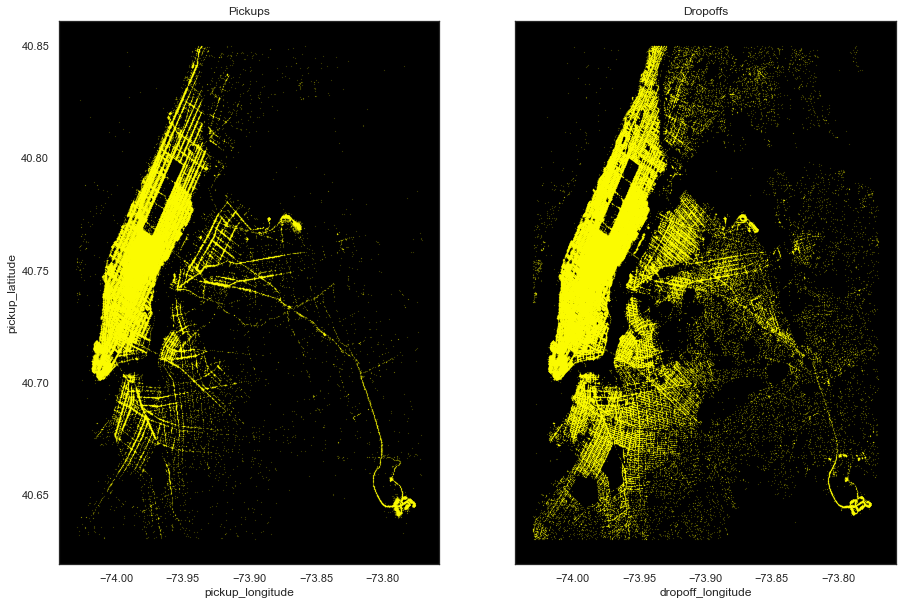

In [15]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True,figsize=(15,10))

train.plot(kind='scatter', x='pickup_longitude', y='pickup_latitude',
                color='yellow', 
                s=.02, alpha=.6, subplots=True, ax=ax1)
ax1.set_title("Pickups")
ax1.set_facecolor('black')

train.plot(kind='scatter', x='dropoff_longitude', y='dropoff_latitude',
                color='yellow', 
                s=.02, alpha=.6, subplots=True, ax=ax2)
ax2.set_title("Dropoffs")
ax2.set_facecolor('black') 

# And Another one 
Trips from La Guradia Airport

In [16]:
#co-ordinates
LaGuardia = {
    "minLat": 40.76,
    "maxLat": 40.78,
    "minLong": -73.895,
    "maxLong": -73.855
}
train['pickup_datetime'] = pd.to_datetime(train.pickup_datetime)
train['dropoff_datetime'] = pd.to_datetime(train.dropoff_datetime)

LaGuardiaData = train[(train['pickup_longitude'].apply(lambda x: (x >=LaGuardia["minLong"]) & (x <= LaGuardia["maxLong"])))]
LaGuardiaData = train[(train['pickup_latitude'].apply(lambda x: (x >=LaGuardia["minLat"]) & (x <= LaGuardia["maxLat"])))]
LaGuardiaData = train[(train['dropoff_longitude'].apply(lambda x: (x >=LaGuardia["minLong"]) & (x <= LaGuardia["maxLong"])))]
LaGuardiaData = train[(train['dropoff_latitude'].apply(lambda x: (x >=LaGuardia["minLat"]) & (x <= LaGuardia["maxLat"])))]

m = folium.Map(
    location=[40.7769, -73.8740],
    zoom_start=12
)
folium.Marker(location=[40.7769, -73.8740],icon=folium.Icon(color='black') ,popup='LA Guardia International Airport').add_to(m)

shortTripsDF=LaGuardiaData[LaGuardiaData.trip_duration==900]

lines = [
    {
        'coordinates': [
            [shortTripsDF.pickup_longitude.iloc[index], shortTripsDF.pickup_latitude.iloc[index]],
            [shortTripsDF.dropoff_longitude.iloc[index], shortTripsDF.dropoff_latitude.iloc[index]],
        ],
        'dates': [
        str(shortTripsDF.pickup_datetime.iloc[index]),
        str(shortTripsDF.dropoff_datetime.iloc[index])
        ],
        'color': 'gold'
    }
    for index in range(10)
]
features = [
    {
        'type': 'Feature',
        'geometry': {
            'type': 'LineString',
            'coordinates': line['coordinates'],
        },
        'properties': {
            'times': line['dates'],
            'style': {
                'color': line['color'],
                'weight': line['weight'] if 'weight' in line else 10
            }
        }
    }
    for line in lines
]


plugins.TimestampedGeoJson({
    'type': 'FeatureCollection',
    'features': features,
}, period='PT24H', add_last_point=True).add_to(m)
m

## Let's get back and be serious lol

In [17]:
# getting to know our dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
id                    1458644 non-null object
vendor_id             1458644 non-null int64
pickup_datetime       1458644 non-null object
dropoff_datetime      1458644 non-null object
passenger_count       1458644 non-null int64
pickup_longitude      1458644 non-null float64
pickup_latitude       1458644 non-null float64
dropoff_longitude     1458644 non-null float64
dropoff_latitude      1458644 non-null float64
store_and_fwd_flag    1458644 non-null object
trip_duration         1458644 non-null int64
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


# Clearly there is no missing values, you are lucky bro!!

In [18]:
#describe the data
data.describe()

vendor_id  passenger_count  pickup_longitude  pickup_latitude  \
count  1.458644e+06     1.458644e+06      1.458644e+06     1.458644e+06   
mean   1.534950e+00     1.664530e+00     -7.397349e+01     4.075092e+01   
std    4.987772e-01     1.314242e+00      7.090186e-02     3.288119e-02   
min    1.000000e+00     0.000000e+00     -1.219333e+02     3.435970e+01   
25%    1.000000e+00     1.000000e+00     -7.399187e+01     4.073735e+01   
50%    2.000000e+00     1.000000e+00     -7.398174e+01     4.075410e+01   
75%    2.000000e+00     2.000000e+00     -7.396733e+01     4.076836e+01   
max    2.000000e+00     9.000000e+00     -6.133553e+01     5.188108e+01   

       dropoff_longitude  dropoff_latitude  trip_duration  
count       1.458644e+06      1.458644e+06   1.458644e+06  
mean       -7.397342e+01      4.075180e+01   9.594923e+02  
std         7.064327e-02      3.589056e-02   5.237432e+03  
min        -1.219333e+02      3.218114e+01   1.000000e+00  
25%        -7.399133e+01      4.073588e+01   3.970000e+02  
50%        -7.397975e+01      4.075452e+01   6.620000e+02  
75%        -7.396301e+01      4.076981e+01   1.075000e+03  
max        -6.133553e+01      4.392103e+01   3.526282e+06

In [19]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
data.describe()

vendor_id  passenger_count  pickup_longitude  pickup_latitude  \
count 1458644.00       1458644.00        1458644.00       1458644.00   
mean        1.53             1.66            -73.97            40.75   
std         0.50             1.31              0.07             0.03   
min         1.00             0.00           -121.93            34.36   
25%         1.00             1.00            -73.99            40.74   
50%         2.00             1.00            -73.98            40.75   
75%         2.00             2.00            -73.97            40.77   
max         2.00             9.00            -61.34            51.88   

       dropoff_longitude  dropoff_latitude  trip_duration  
count         1458644.00        1458644.00     1458644.00  
mean              -73.97             40.75         959.49  
std                 0.07              0.04        5237.43  
min              -121.93             32.18           1.00  
25%               -73.99             40.74         397.00  
50%               -73.98             40.75         662.00  
75%               -73.96             40.77        1075.00  
max               -61.34             43.92     3526282.00

# Univariate Analysis
We need to explore the features and perform Univariate Analysis. Anlysing single feature is called Univariate Analysis.


### Trip Duration

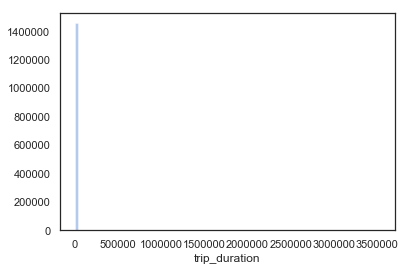

In [20]:
sns.distplot(data.trip_duration, kde=False, bins = 90);

Some of the trips are taking so much time and they are long trips. Thought they are few compared to the rest but this could harm the model. Let transform the duration and the the log.


In [21]:
# Creating a new column that take the log values of the trip duration
train['log_trip_duration'] = np.log1p(train['trip_duration'].values)

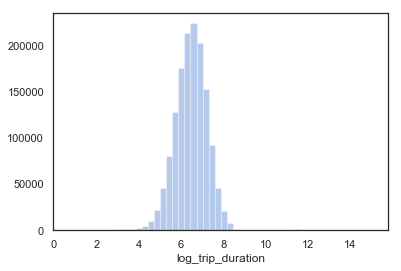

In [22]:
# let's plot the log trip duration
sns.distplot(train.log_trip_duration, kde=False);

Do you see we smoothed out the outliers effect by mathematically transforming the values of the trip duration.

### Passenger Count

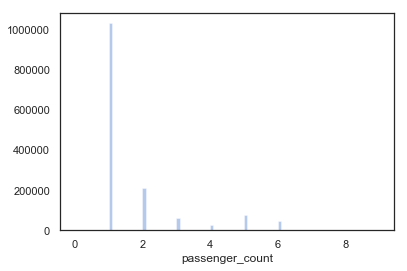

In [23]:
sns.distplot(data.passenger_count, kde=False, bins = 90);

### Vendor ID

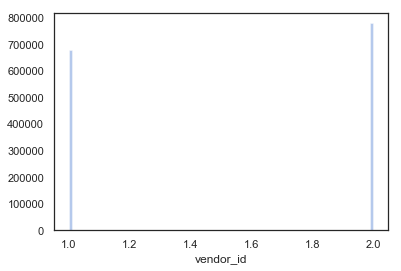

In [24]:
sns.distplot(data.vendor_id, kde=False, bins = 90);

# Features Engineering

In [25]:
# Let's have a look again at what we have
data.head()

id  vendor_id      pickup_datetime     dropoff_datetime  \
0  id2875421          2  2016-03-14 17:24:55  2016-03-14 17:32:30   
1  id2377394          1  2016-06-12 00:43:35  2016-06-12 00:54:38   
2  id3858529          2  2016-01-19 11:35:24  2016-01-19 12:10:48   
3  id3504673          2  2016-04-06 19:32:31  2016-04-06 19:39:40   
4  id2181028          2  2016-03-26 13:30:55  2016-03-26 13:38:10   

   passenger_count  pickup_longitude  pickup_latitude  dropoff_longitude  \
0                1            -73.98            40.77             -73.96   
1                1            -73.98            40.74             -74.00   
2                1            -73.98            40.76             -74.01   
3                1            -74.01            40.72             -74.01   
4                1            -73.97            40.79             -73.97   

   dropoff_latitude store_and_fwd_flag  trip_duration  
0             40.77                  N            455  
1             40.73                  N            663  
2             40.71                  N           2124  
3             40.71                  N            429  
4             40.78                  N            435

### Let's address the following:
1. Pickup/Dropoff datetime is in timestamp.
2. Trip duration has outliers.
3. latitude and longitude values are raw.
4. Store and froward flag is Categorical.

### 1. Enigneering date and time:
- Extract Dates.
- Day of the month.
- Month of the Year.
- weekday.
- week of the year.
- hour of the day.
- minute of the hour.
- day of the year.

In [26]:
#Let's check the datatype for our set
data.info()

#Observe that pickup_datetime & dropoff_datetime are objects aka string

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
id                    1458644 non-null object
vendor_id             1458644 non-null int64
pickup_datetime       1458644 non-null object
dropoff_datetime      1458644 non-null object
passenger_count       1458644 non-null int64
pickup_longitude      1458644 non-null float64
pickup_latitude       1458644 non-null float64
dropoff_longitude     1458644 non-null float64
dropoff_latitude      1458644 non-null float64
store_and_fwd_flag    1458644 non-null object
trip_duration         1458644 non-null int64
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


In [27]:
# Convert our objects into dates
data['pickup_datetime'] = pd.to_datetime(data['pickup_datetime'])
data['dropoff_datetime'] = pd.to_datetime(data['dropoff_datetime'])

In [28]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
id                    1458644 non-null object
vendor_id             1458644 non-null int64
pickup_datetime       1458644 non-null datetime64[ns]
dropoff_datetime      1458644 non-null datetime64[ns]
passenger_count       1458644 non-null int64
pickup_longitude      1458644 non-null float64
pickup_latitude       1458644 non-null float64
dropoff_longitude     1458644 non-null float64
dropoff_latitude      1458644 non-null float64
store_and_fwd_flag    1458644 non-null object
trip_duration         1458644 non-null int64
dtypes: datetime64[ns](2), float64(4), int64(3), object(2)
memory usage: 122.4+ MB


#### pickup

In [29]:
# Dates
data['pickup_date'] = data['pickup_datetime'].dt.date

# day of month 1 day to 30/31 days
data['pickup_day'] = data['pickup_datetime'].dt.day

#month of year 1 to 12
data['pickup_month'] = data['pickup_datetime'].dt.month

#weekday 0 to 6
data['pickup_weekday'] = data['pickup_datetime'].dt.weekday

#week of year
data['pickup_weekofyear'] = data['pickup_datetime'].dt.weekofyear

#hour of day 0 to 23
data['pickup_hour'] = data['pickup_datetime'].dt.hour

#minute of hour
data['pickup_minute'] = data['pickup_datetime'].dt.minute

# day of year
data['pickup_dayofyear'] = data['pickup_datetime'].dt.dayofyear

# pickup date in seconds
data['pickup_dt'] = (data['pickup_datetime'] - data['pickup_datetime'].min()).dt.total_seconds()

# pickup week per hour
data['pickup_week_hour'] = data['pickup_weekday'] * 24 + data['pickup_hour']

#### Dropoff

In [30]:
# Dates
data['dropoff_date'] = data['dropoff_datetime'].dt.date

# day of month 1 day to 30/31 days
data['dropoff_day'] = data['dropoff_datetime'].dt.day

#month of year 1 to 12
data['dropoff_month'] = data['dropoff_datetime'].dt.month

#weekday 0 to 6
data['dropoff_weekday'] = data['dropoff_datetime'].dt.weekday

#week of year
data['dropoff_weekofyear'] = data['dropoff_datetime'].dt.weekofyear

#hour of day 0 to 23
data['dropoff_hour'] = data['dropoff_datetime'].dt.hour

#minute of hour
data['dropoff_minute'] = data['dropoff_datetime'].dt.minute

# day of year
data['dropoff_dayofyear'] = data['dropoff_datetime'].dt.dayofyear

# pickup date in seconds
data['dropoff_dt'] = (data['dropoff_datetime'] - data['dropoff_datetime'].min()).dt.total_seconds()

# dropoff week per hour
data['dropoff_week_hour'] = data['dropoff_weekday'] * 24 + data['dropoff_hour']

In [31]:
data['pickup_date'] = pd.to_datetime(data['pickup_date'])
data['dropoff_date'] = pd.to_datetime(data['dropoff_date'])



data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 31 columns):
id                    1458644 non-null object
vendor_id             1458644 non-null int64
pickup_datetime       1458644 non-null datetime64[ns]
dropoff_datetime      1458644 non-null datetime64[ns]
passenger_count       1458644 non-null int64
pickup_longitude      1458644 non-null float64
pickup_latitude       1458644 non-null float64
dropoff_longitude     1458644 non-null float64
dropoff_latitude      1458644 non-null float64
store_and_fwd_flag    1458644 non-null object
trip_duration         1458644 non-null int64
pickup_date           1458644 non-null datetime64[ns]
pickup_day            1458644 non-null int64
pickup_month          1458644 non-null int64
pickup_weekday        1458644 non-null int64
pickup_weekofyear     1458644 non-null int64
pickup_hour           1458644 non-null int64
pickup_minute         1458644 non-null int64
pickup_dayofyear      1458644 non-null i

In [32]:
data.head()

id  vendor_id     pickup_datetime    dropoff_datetime  \
0  id2875421          2 2016-03-14 17:24:55 2016-03-14 17:32:30   
1  id2377394          1 2016-06-12 00:43:35 2016-06-12 00:54:38   
2  id3858529          2 2016-01-19 11:35:24 2016-01-19 12:10:48   
3  id3504673          2 2016-04-06 19:32:31 2016-04-06 19:39:40   
4  id2181028          2 2016-03-26 13:30:55 2016-03-26 13:38:10   

   passenger_count  pickup_longitude  pickup_latitude  dropoff_longitude  \
0                1            -73.98            40.77             -73.96   
1                1            -73.98            40.74             -74.00   
2                1            -73.98            40.76             -74.01   
3                1            -74.01            40.72             -74.01   
4                1            -73.97            40.79             -73.97   

   dropoff_latitude store_and_fwd_flag        ...          dropoff_date  \
0             40.77                  N        ...            2016-03-14   
1             40.73                  N        ...            2016-06-12   
2             40.71                  N        ...            2016-01-19   
3             40.71                  N        ...            2016-04-06   
4             40.78                  N        ...            2016-03-26   

  dropoff_day  dropoff_month  dropoff_weekday  dropoff_weekofyear  \
0          14              3                0                  11   
1          12              6                6                  23   
2          19              1                1                   3   
3           6              4                2                  14   
4          26              3                5                  12   

   dropoff_hour  dropoff_minute  dropoff_dayofyear  dropoff_dt  \
0            17              32                 74  6370139.00   
1             0              54                164 14086267.00   
2            12              10                 19  1598837.00   
3            19              39                 97  8364969.00   
4            13              38                 86  7392879.00   

   dropoff_week_hour  
0                 17  
1                144  
2                 36  
3                 67  
4                133  

[5 rows x 31 columns]

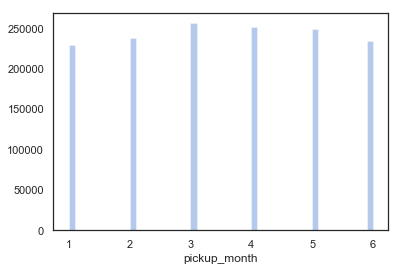

In [33]:
# pickup month destribution
sns.distplot(data.pickup_month, kde=False);

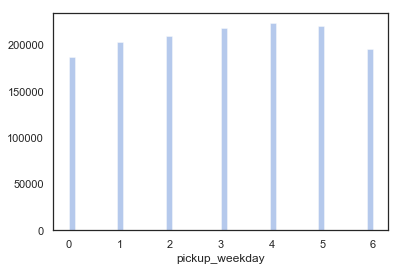

In [34]:
# pickup weekday destribution
sns.distplot(data.pickup_weekday, kde=False);

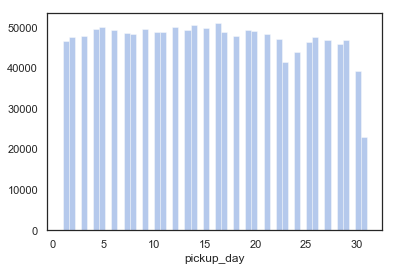

In [35]:
# pickup day of the month destribution
sns.distplot(data.pickup_day, kde=False);

### 2. Trip duration
There are some outliers and we need to smooth them out by taking the mathematical log to transform the values into a small distance reducing the effect of the outliers.

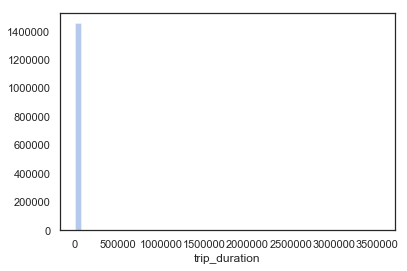

In [36]:
sns.distplot(data.trip_duration, kde=False);

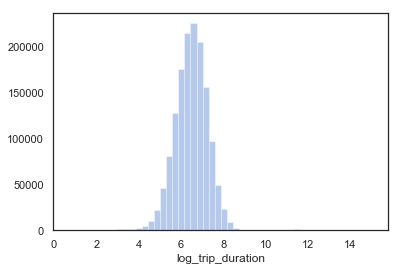

In [37]:
data['log_trip_duration'] = np.log1p(data['trip_duration'].values)

sns.distplot(data.log_trip_duration, kde=False);

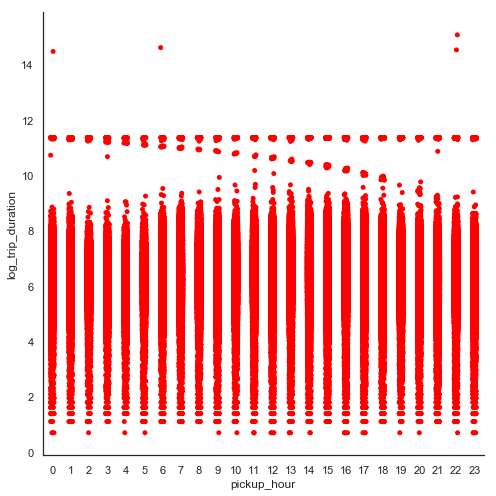

In [38]:
sns.catplot(x="pickup_hour", y="log_trip_duration", data=data,color='red',height=7);

## 3. latitude and longitude

In [39]:
# Creating new feautes 

data['haversine_distance'] = data.apply(lambda row: haversine( (row['pickup_latitude'], row['pickup_longitude']), (row['dropoff_latitude'], row['dropoff_longitude']) ), axis=1)
data['log_haversine_distance'] = np.log1p(data['haversine_distance'])

def manhattan_distance(x,y):
  return sum(abs(a-b) for a,b in zip(x,y))

def euclidean_distance(x,y):
  return sqrt(sum(pow(a-b,2) for a, b in zip(x, y)))

data['euclidean_distance'] = data.apply(lambda row: euclidean_distance( (row['pickup_latitude'], row['pickup_longitude']), (row['dropoff_latitude'], row['dropoff_longitude']) ), axis=1)

data['manhattan_distance'] = data.apply(lambda row: manhattan_distance( (row['pickup_latitude'], row['pickup_longitude']), (row['dropoff_latitude'], row['dropoff_longitude']) ), axis=1)

In [40]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 36 columns):
id                        1458644 non-null object
vendor_id                 1458644 non-null int64
pickup_datetime           1458644 non-null datetime64[ns]
dropoff_datetime          1458644 non-null datetime64[ns]
passenger_count           1458644 non-null int64
pickup_longitude          1458644 non-null float64
pickup_latitude           1458644 non-null float64
dropoff_longitude         1458644 non-null float64
dropoff_latitude          1458644 non-null float64
store_and_fwd_flag        1458644 non-null object
trip_duration             1458644 non-null int64
pickup_date               1458644 non-null datetime64[ns]
pickup_day                1458644 non-null int64
pickup_month              1458644 non-null int64
pickup_weekday            1458644 non-null int64
pickup_weekofyear         1458644 non-null int64
pickup_hour               1458644 non-null int64
pickup_minute    

### Let's look into the distribution of the distance algorithms we have

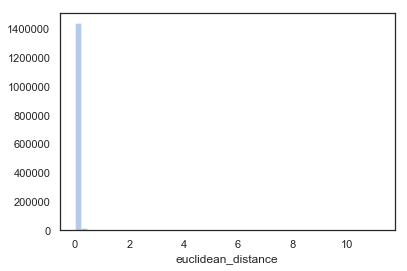

In [41]:
sns.distplot(data.euclidean_distance, kde=False);

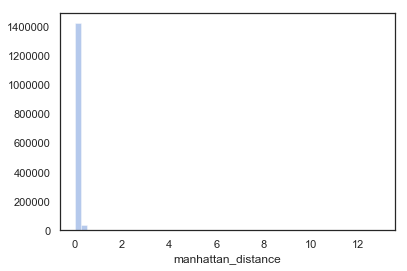

In [42]:
sns.distplot(data.manhattan_distance, kde=False);

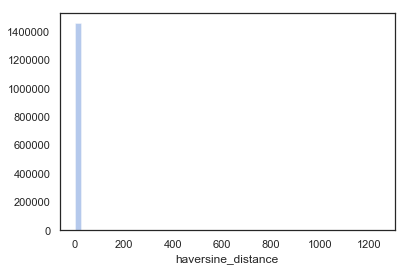

In [43]:
sns.distplot(data.haversine_distance, kde=False);

You can see clearly that there are outliers in these destince measures though we have taken the log of the haversine_distance, we still need to perform the same for the euclidean and manhattan distance. Look below how the log of the haversine_distance distribution appears.

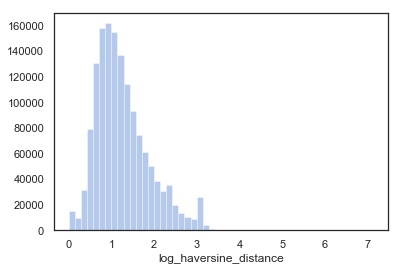

In [44]:
sns.distplot(data.log_haversine_distance, kde=False);

In [45]:
# now let's take the log
data['log_euclidean_distance'] = np.log1p(data['euclidean_distance'])
data['log_manhattan_distance'] = np.log1p(data['manhattan_distance'])


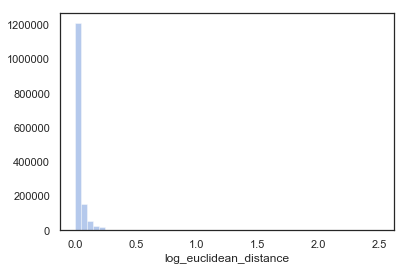

In [46]:
# let's look at them again

sns.distplot(data.log_euclidean_distance, kde=False);

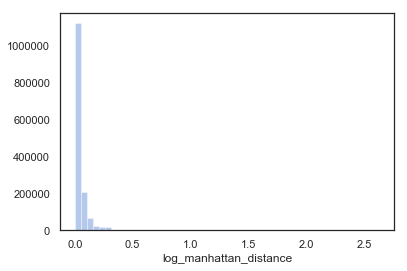

In [47]:
sns.distplot(data.log_manhattan_distance, kde=False);

# Label Encoding

In [48]:
#print the unique attributes of this column
data['store_and_fwd_flag'].unique()

array(['N', 'Y'], dtype=object)

#### Machine Learning algorithms expects all features to be numberic therefore we have convert all categorical features into a numeric representation. There are several methods that performs the same prupose but with variations. Lable encoding is one of the methods we will use here. The example below:

In [49]:
from sklearn import preprocessing 

# input labels 
input_labels = ['red', 'black', 'red', 'green', 'black', 'yellow', 'white'] 


# Create label encoder and fit the labels 
encoder = preprocessing.LabelEncoder() 
encoder.fit(input_labels) 


# Print the mapping  
print("\nLabel mapping:") 
for i, item in enumerate(encoder.classes_): 
    print(item, '-->', i) 


Label mapping:
black --> 0
green --> 1
red --> 2
white --> 3
yellow --> 4


In [50]:
# Encode a set of randomly ordered labels using the encoder 
test_labels = ['green', 'red', 'black'] 
encoded_values = encoder.transform(test_labels) 
print("\nLabels =", test_labels) 
print("Encoded values =", list(encoded_values)) 



Labels = ['green', 'red', 'black']
Encoded values = [1, 2, 0]


In [51]:
# Decode a set of values using the encoder 
encoded_values = [3, 0, 4, 1] 
decoded_list = encoder.inverse_transform(encoded_values) 
print("\nEncoded values =", encoded_values) 
print("Decoded labels =", list(decoded_list)) 


Encoded values = [3, 0, 4, 1]
Decoded labels = ['white', 'black', 'yellow', 'green']


### Now let's apply this method for our *store_and_fwd_flag* column

In [52]:
# first define the varaibles
input_labels = ['N', 'Y'] 

# Create label encoder and fit the labels 
encoder = preprocessing.LabelEncoder() 
encoder.fit(input_labels) 


# Print the mapping  
print("\nLabel mapping:") 
for i, item in enumerate(encoder.classes_): 
    print(item, '-->', i) 


Label mapping:
N --> 0
Y --> 1


In [53]:
#Encode our column
data['En_store_and_fwd_flag'] = encoder.fit_transform(data['store_and_fwd_flag'].astype('str'))


In [54]:
#Let's have a look into our dataset
data.head()

id  vendor_id     pickup_datetime    dropoff_datetime  \
0  id2875421          2 2016-03-14 17:24:55 2016-03-14 17:32:30   
1  id2377394          1 2016-06-12 00:43:35 2016-06-12 00:54:38   
2  id3858529          2 2016-01-19 11:35:24 2016-01-19 12:10:48   
3  id3504673          2 2016-04-06 19:32:31 2016-04-06 19:39:40   
4  id2181028          2 2016-03-26 13:30:55 2016-03-26 13:38:10   

   passenger_count  pickup_longitude  pickup_latitude  dropoff_longitude  \
0                1            -73.98            40.77             -73.96   
1                1            -73.98            40.74             -74.00   
2                1            -73.98            40.76             -74.01   
3                1            -74.01            40.72             -74.01   
4                1            -73.97            40.79             -73.97   

   dropoff_latitude store_and_fwd_flag          ...            dropoff_dt  \
0             40.77                  N          ...            6370139.00   
1             40.73                  N          ...           14086267.00   
2             40.71                  N          ...            1598837.00   
3             40.71                  N          ...            8364969.00   
4             40.78                  N          ...            7392879.00   

  dropoff_week_hour  log_trip_duration  haversine_distance  \
0                17               6.12                1.50   
1               144               6.50                1.81   
2                36               7.66                6.39   
3                67               6.06                1.49   
4               133               6.08                1.19   

   log_haversine_distance  euclidean_distance  manhattan_distance  \
0                    0.92                0.02                0.02   
1                    1.03                0.02                0.03   
2                    2.00                0.06                0.08   
3                    0.91                0.01                0.02   
4                    0.78                0.01                0.01   

   log_euclidean_distance  log_manhattan_distance  En_store_and_fwd_flag  
0                    0.02                    0.02                      0  
1                    0.02                    0.03                      0  
2                    0.06                    0.08                      0  
3                    0.01                    0.02                      0  
4                    0.01                    0.01                      0  

[5 rows x 39 columns]

In [55]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 39 columns):
id                        1458644 non-null object
vendor_id                 1458644 non-null int64
pickup_datetime           1458644 non-null datetime64[ns]
dropoff_datetime          1458644 non-null datetime64[ns]
passenger_count           1458644 non-null int64
pickup_longitude          1458644 non-null float64
pickup_latitude           1458644 non-null float64
dropoff_longitude         1458644 non-null float64
dropoff_latitude          1458644 non-null float64
store_and_fwd_flag        1458644 non-null object
trip_duration             1458644 non-null int64
pickup_date               1458644 non-null datetime64[ns]
pickup_day                1458644 non-null int64
pickup_month              1458644 non-null int64
pickup_weekday            1458644 non-null int64
pickup_weekofyear         1458644 non-null int64
pickup_hour               1458644 non-null int64
pickup_minute    

In [56]:
data.describe()

vendor_id  passenger_count  pickup_longitude  pickup_latitude  \
count 1458644.00       1458644.00        1458644.00       1458644.00   
mean        1.53             1.66            -73.97            40.75   
std         0.50             1.31              0.07             0.03   
min         1.00             0.00           -121.93            34.36   
25%         1.00             1.00            -73.99            40.74   
50%         2.00             1.00            -73.98            40.75   
75%         2.00             2.00            -73.97            40.77   
max         2.00             9.00            -61.34            51.88   

       dropoff_longitude  dropoff_latitude  trip_duration  pickup_day  \
count         1458644.00        1458644.00     1458644.00  1458644.00   
mean              -73.97             40.75         959.49       15.50   
std                 0.07              0.04        5237.43        8.70   
min              -121.93             32.18           1.00        1.00   
25%               -73.99             40.74         397.00        8.00   
50%               -73.98             40.75         662.00       15.00   
75%               -73.96             40.77        1075.00       23.00   
max               -61.34             43.92     3526282.00       31.00   

       pickup_month  pickup_weekday          ...            dropoff_dt  \
count    1458644.00      1458644.00          ...            1458644.00   
mean           3.52            3.05          ...            7899773.43   
std            1.68            1.95          ...            4455328.78   
min            1.00            0.00          ...                  0.00   
25%            2.00            1.00          ...            4122121.50   
50%            4.00            3.00          ...            7925501.00   
75%            5.00            5.00          ...           11678840.75   
max            6.00            6.00          ...           15807512.00   

       dropoff_week_hour  log_trip_duration  haversine_distance  \
count         1458644.00         1458644.00          1458644.00   
mean               86.91               6.47                3.44   
std                46.81               0.80                4.30   
min                 0.00               0.69                0.00   
25%                45.00               5.99                1.23   
50%                89.00               6.50                2.09   
75%               128.00               6.98                3.88   
max               167.00              15.08             1240.91   

       log_haversine_distance  euclidean_distance  manhattan_distance  \
count              1458644.00          1458644.00          1458644.00   
mean                     1.25                0.04                0.05   
std                      0.63                0.05                0.06   
min                      0.00                0.00                0.00   
25%                      0.80                0.01                0.02   
50%                      1.13                0.02                0.03   
75%                      1.58                0.04                0.05   
max                      7.12               11.19               12.91   

       log_euclidean_distance  log_manhattan_distance  En_store_and_fwd_flag  
count              1458644.00              1458644.00             1458644.00  
mean                     0.03                    0.04                   0.01  
std                      0.04                    0.05                   0.07  
min                      0.00                    0.00                   0.00  
25%                      0.01                    0.02                   0.00  
50%                      0.02                    0.03                   0.00  
75%                      0.04                    0.05                   0.00  
max                      2.50                    2.63                   1.00  

[8 rows x 33 columns]

In [ ]:
#Produce this into a file
data.to_csv('Dataset/Large NYC.csv')